In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np


In [ ]:
FileOG = "./data/Excel/IMPORTACION-HIDROCARBUROS-VOLUMEN-2025-05.xlsx"
importacion = pd.read_excel(FileOG, sheet_name="IMPORTACION", engine="openpyxl")

importacionCSV2025 = "./data/CSV/importacionToDate.csv"

importacion.to_csv(importacionCSV2025, index=False)

In [4]:
importacion_df = pd.read_csv("./data/CSV/importacionToDate.csv")

columnas_deseadas = ["Fecha", "Gasolina regular", "Gasolina superior"]

importacion_filtrado = importacion_df[columnas_deseadas]

importacion_filtrado.to_csv("./data/CSV/importacionToDate.csv", index=False)

print("Archivos 'importacionToDate.csv' actualizado correctamente.")

Archivos 'importacionToDate.csv' actualizado correctamente.


In [7]:
# Cargar CSV o DataFrame
impToDate = pd.read_csv('./data/CSV/importacion.csv', parse_dates=['Fecha'])

print(impToDate.head())

       Fecha  Gasolina regular  Gasolina superior  Diesel alto azufre
0 2001-01-01         177776.50          373963.96           566101.99
1 2001-02-01         123115.99          243091.07           489525.80
2 2001-03-01         161726.42          312084.38           575559.68
3 2001-04-01         127338.74          285054.89           437745.42
4 2001-05-01         168730.19          300913.67           552609.13


21:37:21 - cmdstanpy - INFO - Chain [1] start processing
21:37:21 - cmdstanpy - INFO - Chain [1] done processing


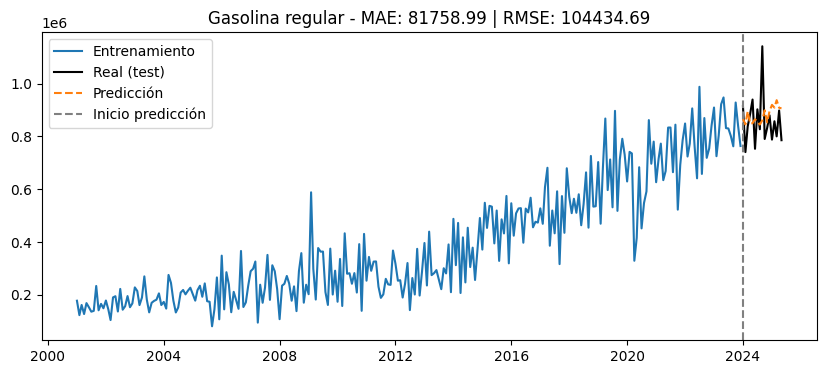

21:37:21 - cmdstanpy - INFO - Chain [1] start processing
21:37:21 - cmdstanpy - INFO - Chain [1] done processing


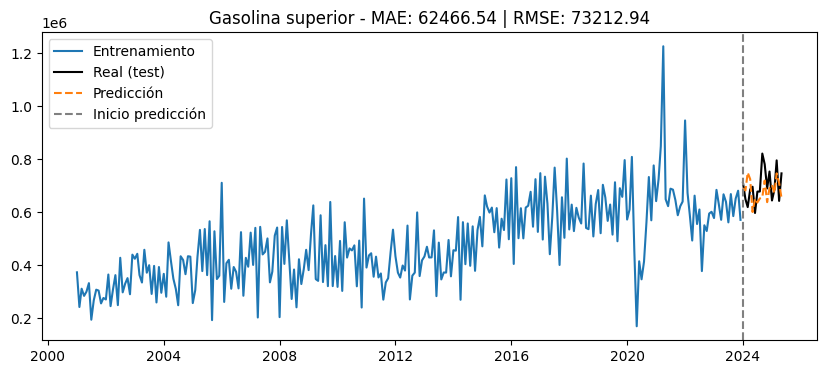

21:37:22 - cmdstanpy - INFO - Chain [1] start processing
21:37:22 - cmdstanpy - INFO - Chain [1] done processing


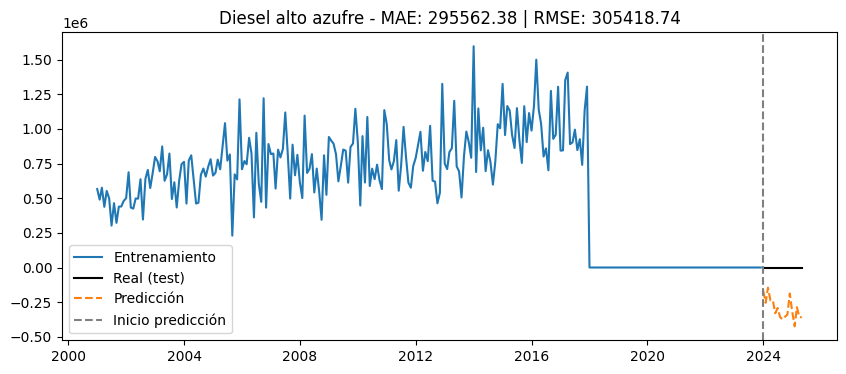

In [13]:
def predecir_y_evaluar(df, columna, inicio_pred='2024-01-01', fin_pred='2025-05-01'):
    datos = df[['Fecha', columna]].rename(columns={'Fecha': 'ds', columna: 'y'})
    
    train = datos[datos['ds'] < inicio_pred]
    test = datos[(datos['ds'] >= inicio_pred) & (datos['ds'] <= fin_pred)]
    
    modelo = Prophet()
    modelo.fit(train)

    futuro = modelo.make_future_dataframe(periods=17, freq='MS')
    forecast = modelo.predict(futuro)

    pred = forecast[['ds', 'yhat']].set_index('ds').loc[inicio_pred:fin_pred]
    test = test.set_index('ds')
    
    mae = mean_absolute_error(test['y'], pred['yhat'])
    mse = mean_squared_error(test['y'], pred['yhat'])
    rmse = np.sqrt(mse)


    # Gráfica
    plt.figure(figsize=(10, 4))
    plt.plot(train['ds'], train['y'], label='Entrenamiento')
    plt.plot(test.index, test['y'], label='Real (test)', color='black')
    plt.plot(pred.index, pred['yhat'], label='Predicción', linestyle='--')
    plt.axvline(pd.to_datetime(inicio_pred), color='gray', linestyle='--', label='Inicio predicción')
    plt.title(f'{columna} - MAE: {mae:.2f} | RMSE: {rmse:.2f}')
    plt.legend()
    plt.show()
    
    return pred, mae, rmse

impToDate['Fecha'] = pd.to_datetime(impToDate['Fecha'])

# Gasolina regular
pred_gr, mae_gr, rmse_gr = predecir_y_evaluar(impToDate, 'Gasolina regular')

# Gasolina superior
pred_gs, mae_gs, rmse_gs = predecir_y_evaluar(impToDate, 'Gasolina superior')

# Diesel alto azufre
pred_da, mae_da, rmse_da = predecir_y_evaluar(impToDate, 'Diesel alto azufre')



In [14]:
resultados = pd.DataFrame({
    'Serie': ['Gasolina regular', 'Gasolina superior', 'Diesel alto azufre'],
    'MAE': [mae_gr, mae_gs, mae_da],
    'RMSE': [rmse_gr, rmse_gs, rmse_da]
})

print(resultados)

                Serie            MAE           RMSE
0    Gasolina regular   81758.988352  104434.694252
1   Gasolina superior   62466.541647   73212.937505
2  Diesel alto azufre  295562.379959  305418.739325


Se puede observar que tanto la predicción de la gasolina regular como la superior tuvieron un desempeño bastante bueno. Aún así, en el de la gasolina regular podemos ver que hubo un pico que el modelo prophet no logró predecir. Por otro lado, el de diesel de alto azufre tiene un desempeño muy malo. Esto era de esperarse, ya que en un momento después del 2016, el diesel cambio de alto azufre a bajo azufre, por lo que su consumo se mantuvo en 0. Esto causa un sesgo bastante grande en las predicciones. Se considera que este último sea retirado del análisis predictivo, pues se sabe que ahora siempre estará en 0. Regresando a la gasolina, se puede observar que durante la época de pandemia (2020-2021), hubo una gran bajada en la importación de ambos tipos. Sin embargo, la gasolina superior tuvo un aumento de importación bastante grande, justo después de esta crisis. Esto puede haber creado un mayor balance en los datos y por eso es que su predicción es más precisa. 